Matplotlib is building the font cache; this may take a moment.


Fetching data for RELIANCE.NS...


/var/folders/dr/1yrd_yts04zc5b6grgklwnl40000gn/T/ipykernel_19801/1040947069.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Calculating strategy signals...
Analyzing performance...

--- BACKTEST RESULTS ---
Period: 2020-01-01 to 2023-12-31

----- BENCHMARK (BUY & HOLD) -----
Total Return: 89.98%
Annual Volatility: 31.18%
Sharpe Ratio: 0.68

----- SMA CROSSOVER STRATEGY -----
Total Return: 53.40%
Annual Volatility: 22.17%
Sharpe Ratio: 0.60
--------------------------

Generating plot...


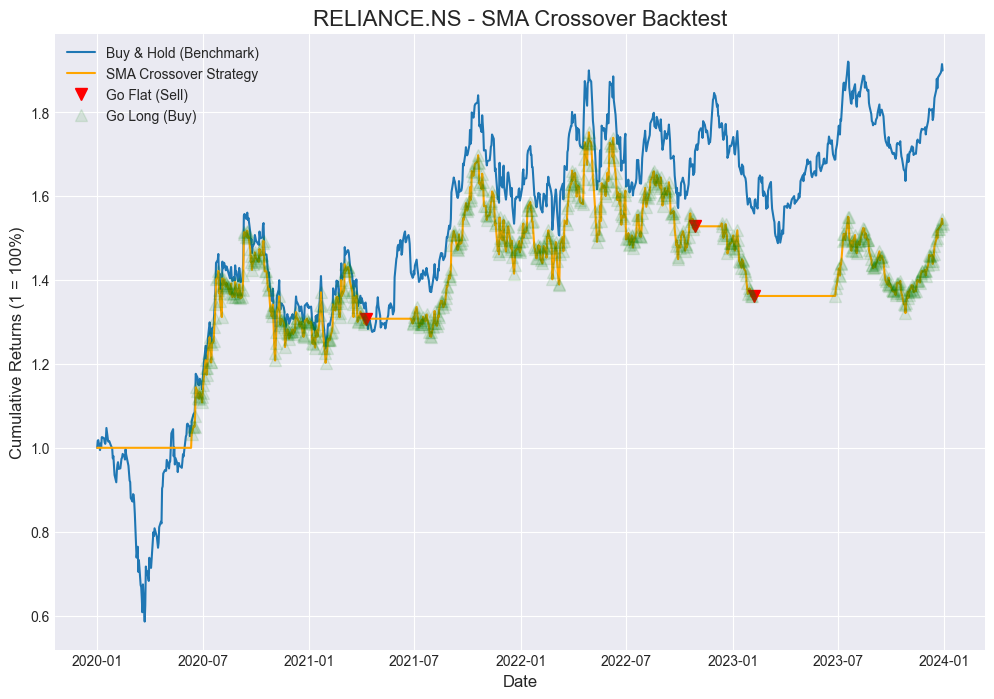

In [1]:
# Import all the libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set plotting style for better visuals
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

def run_backtest(ticker='RELIANCE.NS', start_date='2020-01-01', end_date='2023-12-31'):
    """
    Main function to run the backtest and analysis.
    """
    
    # -----------------------------------------------
    # STEP 1: GET THE DATA
    # -----------------------------------------------
    print(f"Fetching data for {ticker}...")
    data = yf.download(ticker, start=start_date, end=end_date)
    
    if data.empty:
        print("No data fetched. Check ticker or date range.")
        return

    # -----------------------------------------------
    # STEP 2: BUILD THE STRATEGY LOGIC
    # -----------------------------------------------
    print("Calculating strategy signals...")
    
    # Define SMA windows
    short_window = 50  # 50-day moving average
    long_window = 200  # 200-day moving average (a classic "golden cross")

    # Create the SMAs
    data['SMA_Short'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
    data['SMA_Long'] = data['Close'].rolling(window=long_window, min_periods=1).mean()

    # Create the Signal
    # np.where(condition, value_if_true, value_if_false)
    # 1 = "Go Long" (Buy)
    # 0 = "Go Neutral/Flat" (Sell)
    data['Signal'] = np.where(data['SMA_Short'] > data['SMA_Long'], 1, 0)
    
    # Calculate "Positions" - This is what we 'hold' each day.
    # We .shift(1) because we can only act on *yesterday's* signal.
    # You see the cross today, you buy/sell tomorrow.
    data['Position'] = data['Signal'].shift(1).fillna(0)

    # -----------------------------------------------
    # STEP 3: CALCULATE RETURNS & METRICS
    # -----------------------------------------------
    print("Analyzing performance...")
    
    # Calculate daily returns for the stock (Benchmark)
    data['Benchmark_Returns'] = data['Close'].pct_change().fillna(0)
    
    # Calculate daily returns for our strategy
    # Our return is the benchmark return *multiplied* by our position (1 or 0)
    data['Strategy_Returns'] = data['Benchmark_Returns'] * data['Position']

    # Calculate Cumulative Returns (to plot)
    data['Benchmark_Cumulative'] = (1 + data['Benchmark_Returns']).cumprod()
    data['Strategy_Cumulative'] = (1 + data['Strategy_Returns']).cumprod()
    
    # --- Key Metrics ---
    
    # Total Return (as a percentage)
    total_return_bench = (data['Benchmark_Cumulative'].iloc[-1] - 1) * 100
    total_return_strat = (data['Strategy_Cumulative'].iloc[-1] - 1) * 100

    # Volatility (Annualized Standard Deviation)
    # We multiply by sqrt(252) because there are ~252 trading days in a year.
    volatility_bench = data['Benchmark_Returns'].std() * np.sqrt(252) * 100
    volatility_strat = data['Strategy_Returns'].std() * np.sqrt(252) * 100

    # Sharpe Ratio
    # (Mean Annual Return / Annual Volatility)
    # Assuming risk-free rate is 0 for simplicity.
    sharpe_ratio_bench = (data['Benchmark_Returns'].mean() * 252) / (data['Benchmark_Returns'].std() * np.sqrt(252))
    sharpe_ratio_strat = (data['Strategy_Returns'].mean() * 252) / (data['Strategy_Returns'].std() * np.sqrt(252))


    # -----------------------------------------------
    # STEP 4: OUTPUT THE RESULTS
    # -----------------------------------------------
    print("\n--- BACKTEST RESULTS ---")
    print("Period: {} to {}".format(start_date, end_date))
    print("\n----- BENCHMARK (BUY & HOLD) -----")
    print(f"Total Return: {total_return_bench:.2f}%")
    print(f"Annual Volatility: {volatility_bench:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio_bench:.2f}")

    print("\n----- SMA CROSSOVER STRATEGY -----")
    print(f"Total Return: {total_return_strat:.2f}%")
    print(f"Annual Volatility: {volatility_strat:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio_strat:.2f}")
    print("--------------------------\n")

    # -----------------------------------------------
    # STEP 5: PLOT THE RESULTS
    # -----------------------------------------------
    print("Generating plot...")
    plt.figure(figsize=(12, 8))
    
    # Plot P&L curves
    plt.plot(data['Benchmark_Cumulative'], label='Buy & Hold (Benchmark)')
    plt.plot(data['Strategy_Cumulative'], label='SMA Crossover Strategy', color='orange')
    
    # Plot 'Buy' signals
    buy_signals = data[data['Position'] == 1].index
    
    # Plot 'Sell' signals
    # We only plot the *first* sell signal after a buy period for clarity
    sell_signals_filtered = data[(data['Position'] == 0) & (data['Position'].shift(1) == 1)].index
    
    # Plot the buy/sell markers
    # We plot them on the *strategy* curve to show when trades happen
    plt.plot(data.loc[sell_signals_filtered]['Strategy_Cumulative'], 'v', markersize=8, color='r', label='Go Flat (Sell)')
    plt.plot(data.loc[buy_signals]['Strategy_Cumulative'], '^', markersize=8, color='g', label='Go Long (Buy)', alpha=0.1) # Make buy signals faint


    plt.title(f"{ticker} - SMA Crossover Backtest", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Cumulative Returns (1 = 100%)", fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True)
    
    # This line ensures the plot displays in the notebook
    plt.show()


# --- Run the project ---
if __name__ == "__main__":
    # You can change the ticker or dates here
    run_backtest(ticker='RELIANCE.NS', start_date='2020-01-01', end_date='2023-12-31')